In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import shapiro, probplot

In [ ]:
data=pd.read_csv("clean_data.csv")

 ## OLS vs. LinearRegression in Python: What's the Difference?

### 1. Select a Regression Target & Features: A continuous dependent variable (e.g. funding_total_usd)  Independent variables (e.g. funding_rounds, milestones, relationships, etc.)

In [26]:
import statsmodels.api as sm
import pandas as pd

# Your features and target
X = data[['funding_rounds', 'milestones', 'relationships']]
y = data['funding_total_usd_log']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to DataFrame with original column names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)

# Add constant for intercept
X_train_scaled_df = sm.add_constant(X_train_scaled_df)

# Fit OLS model with DataFrame (with column names)
model = sm.OLS(y_train, X_train_scaled_df).fit()

print(model.summary())



                              OLS Regression Results                             
Dep. Variable:     funding_total_usd_log   R-squared:                       0.243
Model:                               OLS   Adj. R-squared:                  0.240
Method:                    Least Squares   F-statistic:                     78.24
Date:                   Thu, 15 May 2025   Prob (F-statistic):           6.74e-44
Time:                           10:11:03   Log-Likelihood:                -1374.2
No. Observations:                    735   AIC:                             2756.
Df Residuals:                        731   BIC:                             2775.
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const         

## Explanation
More funding rounds and stronger relationships increase funding
A predictor is statistically significant if its p-value (P>|t|) is less than 0.05 (standard threshold).

funding_rounds: p = 0.000  → significant ✅

milestones: p = 0.012 → significant ✅

relationships: p = 0.000  → significant ✅

Surprisingly, each additional milestone is associated with a decrease of about 0.17 units in the log of total funding

Intercept: 15.696371434538333
Coefficients:
  funding_rounds: 0.7289966353049786
  milestones: -0.1705945619924273
  relationships: 0.39270767524979605
R-squared on test set: 0.2894564644567734
MSE on test set: 2.1240819843329293


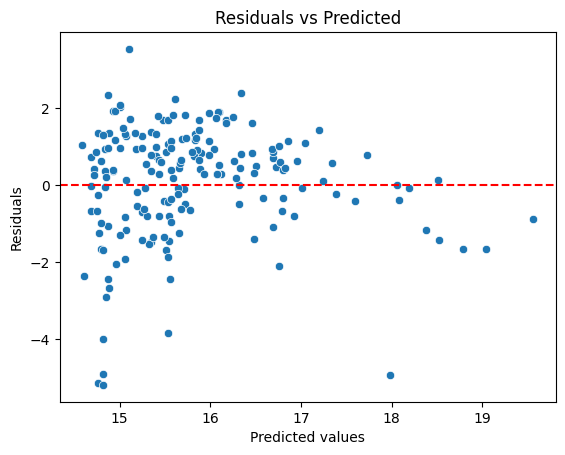

In [ ]:
# Features and target
X = data[['funding_rounds', 'milestones', 'relationships']]
y = data['funding_total_usd_log']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling features (optional but good practice)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Print intercept and coefficients
print("Intercept:", lr_model.intercept_)
print("Coefficients:")
for feature, coef in zip(X.columns, lr_model.coef_):
    print(f"  {feature}: {coef}")

# Predict on test set
y_pred = lr_model.predict(X_test_scaled)

# Evaluate
print("R-squared on test set:", r2_score(y_test, y_pred))
print("MSE on test set:", mean_squared_error(y_test, y_pred))

# Residual plot to check fit
residuals = y_test - y_pred
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.show()



# Let’s perform the BLUE test to check if our linear regression model is reliable 

✅ BLUE Assumptions Checklist
Assumption	How to Check (Method)
1. Linearity	Residuals vs. Fitted Plot
2. No Multicollinearity	Variance Inflation Factor (VIF)
3. Normality of Residuals	Histogram & Q-Q Plot of residuals
4. Homoscedasticity	Residuals vs. Fitted Plot / Breusch-Pagan test
5. No Autocorrelation	Durbin-Watson statistic

### 1. Linearity (residuals vs fitted)

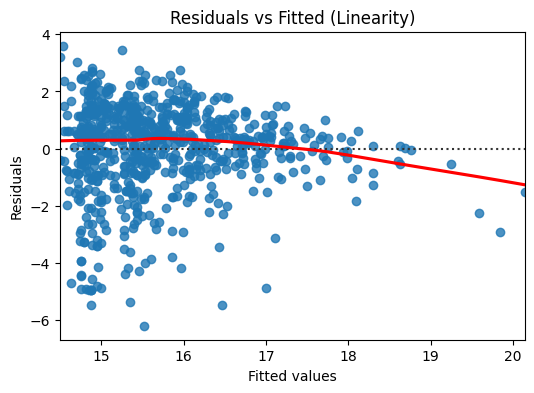

In [ ]:
plt.figure(figsize=(6, 4))
sns.residplot(x=model.fittedvalues, y=model.resid, lowess=True, line_kws={'color': 'red'})
plt.title('Residuals vs Fitted (Linearity)')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()

✅ Interpretation:
Good: Residuals randomly scattered around zero → Linearity assumption is satisfied.

Bad: Clear curves, funnels, or patterns → Model may be missing non-linear relationships.

### 2. Multicollinearity (VIF)

In [ ]:
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("🔁 VIF:\n", vif)

🔁 VIF:
          Variable       VIF
0  funding_rounds  2.807799
1      milestones  3.273868
2   relationships  3.144262


#### VIF Value	Interpretation:<br>Multicollinearity occurs when two or more independent variables in a regression model are highly correlated with each other.
##### < 5	&nbsp;&nbsp;&nbsp;No serious multicollinearity ✅<br>
##### 5–10&nbsp;&nbsp;&nbsp;Moderate concern ⚠️<br>
##### > 10&nbsp;&nbsp;&nbsp;Serious multicollinearity ❌<br><br>

### 3. Normality of Residuals

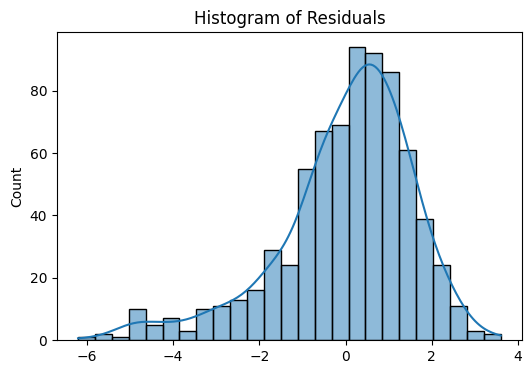

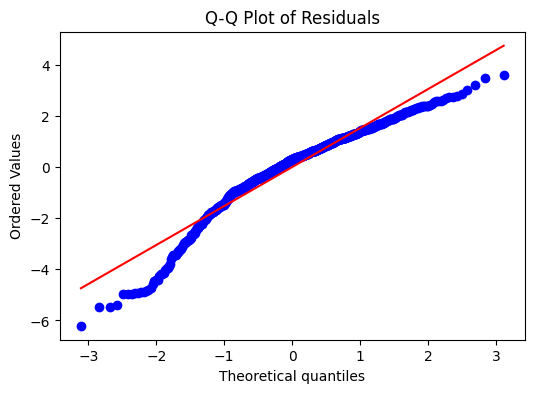

📊 Shapiro-Wilk Test: W=0.9381, p-value=0.0000 -> Not normal


In [ ]:
plt.figure(figsize=(6, 4))
sns.histplot(model.resid, kde=True)
plt.title('Histogram of Residuals')
plt.show()
plt.figure(figsize=(6, 4))
#Q-Q Plot
probplot(model.resid, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()
# Shapiro-Wilk test (normality)
stat, p = shapiro(model.resid)
print(f'📊 Shapiro-Wilk Test: W={stat:.4f}, p-value={p:.4f} -> {"Normal" if p>0.05 else "Not normal"}')

✅ Interpretation:
Histogram: Should resemble a bell curve (normal distribution).if histogram looks somewhat bell-shaped but is skewed, it means the residuals aren't perfectly normal 

Q-Q Plot: Points should lie on the diagonal line.(A Q-Q plot compares the distribution of your residuals to a normal distribution.)

Shapiro-Wilk Test:

p > 0.05 → Residuals are normally distributed ✅

p < 0.05 → Residuals not normal ❌ (affects inference validity)

### 4.Homoscedasticity

In [34]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

# Assuming you already have X_train_scaled and model fitted on X_train_scaled
# Add a constant column to X_train_scaled before the test
X_train_const = sm.add_constant(X_train_scaled)

bp_test = het_breuschpagan(model.resid, X_train_const)
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
print('Breusch-Pagan test:')
for name, value in zip(labels, bp_test):
    print(f'{name}: {value:.4f}')


Breusch-Pagan test:
Lagrange multiplier statistic: 44.6108
p-value: 0.0000
f-value: 15.7450
f p-value: 0.0000


✅ Interpretation:<br>
Homoscedasticity means that the variance of the residuals (errors) is constant across all levels of the independent variables in a regression model.
Why is constant variance of residuals (homoscedasticity) good in a regression model?It ensures reliable inference<br><br>
p > 0.05 → Variance of residuals is constant (homoscedasticity) ✅

p < 0.05 → Heteroscedasticity detected ❌ (violates assumption)

### 5. Autocorrelation (Durbin-Watson)

In [ ]:
dw = sm.stats.durbin_watson(residuals)
print(f'📐 Durbin-Watson: {dw:.4f} (Ideal ~2)')


📐 Durbin-Watson: 1.9972 (Ideal ~2)


Autocorrelation refers to the correlation of residuals (errors) with each other over time or order.

✅ In a good regression model:
Residuals (errors) should be independent — meaning:

The error you make on one observation should not influence the error you make on another.If residuals influence each other, your model is biased in estimating standard errors.

Value ≈ 2 → No autocorrelation

< 2 → Positive autocorrelation

2 → Negative autocorrelation